# Around Heston model and calibration

We offer you the following practical task on the stochastic volatility models and how to put them to work.

Total score is **100**, which will be converted to $25\%$ of the course grade. You have $3$ weeks and a half for this work. **Hard deadline is the 15th of December, 23:59 MSK**.

The file must be sent to **stoch-vol-24-fall@yandex.ru** with topic "stoch-vol Lab2".  Please rename your file as **"SurnameName_Lab2.ipynb"** before sending. 

If you have any questions feel free to ask in Telegram in the **group chat**.

**Full name:** Makhova Anastasia

**Faculty:** of Mechanics and Mathematics, MSU

## Episode 0: Preparations 💅 (0 points)

In [1]:
from typing import Union
from dataclasses import dataclass
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pandas as pd
from py_vollib.black.implied_volatility import implied_volatility_of_undiscounted_option_price
implied_volatility_vec = np.vectorize(implied_volatility_of_undiscounted_option_price)
from py_vollib.black_scholes.implied_volatility import implied_volatility
implied_volatility_vec_2 = np.vectorize(implied_volatility)
import math
from scipy import optimize
import cmath
import scipy.integrate as intg

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

In [2]:
ZONE              = ZoneInfo("Europe/Moscow")
ASSIGNMENT_DT     = datetime(2024, 11, 21, 23, 10, 0, tzinfo=ZONE)
NO_PENALTY_PERIOD = timedelta(days=21)
HARD_DEADLINE     = datetime(2024, 12, 15, 23, 59, 59, tzinfo=ZONE)
MAX_LAB_SCORE = 100

In [3]:
def get_score_multiplier(lab_hand_dt: datetime = datetime.now().astimezone()) -> float:
    """Calculate overeall lab score multiplier.
    
    The function calculates the lab score weighting factor, based on time,
    when the solved lab was handed in. The factor equals 1 during the 
    `NO_PENALTY_PERIOD` starting at the `ASSIGNMENT_DT, then lineary decays
    towards 0 by the `HARD_DEADLINE`date.
    
    Args:
        lab_hand_dt: datetime when the lab is handed in. Now by default. Must be
        timezone-aware.
    
    Returns:
        A factor between 0 and 1, by which the final score will be multiplied.
    """
    assert lab_hand_dt.tzinfo is not None,\
        "The argument must be timezone-aware. Use `datetime.astimezone()` "\
        "to use your local timezone."
    
    if lab_hand_dt < ASSIGNMENT_DT + NO_PENALTY_PERIOD:
        return 1.
    
    decay_period = HARD_DEADLINE - ASSIGNMENT_DT - NO_PENALTY_PERIOD
    elapsed_with_penalty = lab_hand_dt - ASSIGNMENT_DT - NO_PENALTY_PERIOD
    factor = 1. - elapsed_with_penalty.total_seconds() / decay_period.total_seconds()
    return max(0., factor)

In [4]:
HAND_IN_DT = datetime.now().astimezone()
LAB_SCORE = 100
print(f"Final score is {int(LAB_SCORE * get_score_multiplier(HAND_IN_DT))}")

Final score is 100


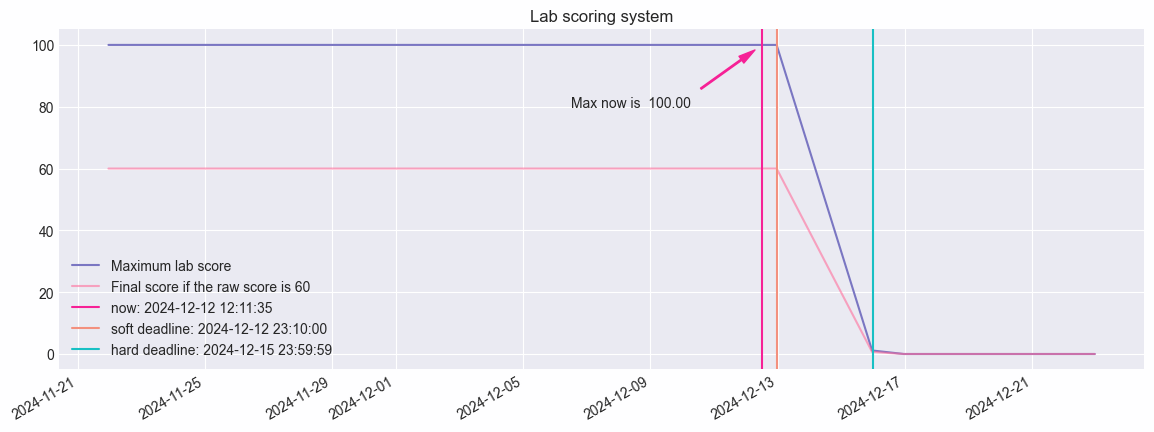

In [5]:
EXAMPLE_SCORE = 60

index = pd.date_range(ASSIGNMENT_DT, HARD_DEADLINE + timedelta(days=7))
mult = index.map(get_score_multiplier)
score = pd.DataFrame(
    index=index,
    data={
        "Maximum lab score": mult * MAX_LAB_SCORE,
        f"Final score if the raw score is {EXAMPLE_SCORE}": mult * EXAMPLE_SCORE,
    }
)

sd = ASSIGNMENT_DT + NO_PENALTY_PERIOD
hd = HARD_DEADLINE
now = datetime.now().astimezone()
score_now = get_score_multiplier(now) * MAX_LAB_SCORE

_, ax = plt.subplots(figsize=(14, 5))
score.plot(ax=ax)
ax.set_title("Lab scoring system")
ax.axvline(now, c="C2", label=f"now: {now:%F %T}")
ax.axvline(sd, c="C4", label=f"soft deadline: {sd:%F %T}")
ax.axvline(hd, c="C3", label=f"hard deadline: {hd:%F %T}")
ax.annotate(
    text=f"Max now is {score_now: .2f}",
    xy=(now, score_now),
    xytext=(now - timedelta(days=6), score_now - 20),
    arrowprops=dict(
        facecolor="C2", edgecolor="C2", shrink=0.1, width=1, headwidth=6
    ),
)
ax.legend()
plt.show()

## Episode 1: Around COS method 🧠 (60 points)

Recall the COS method final formula providing the evaluation of the integral of the payoff function with respect to the underlying proce density

$$
C\approx DF(0, T) 
\left(\frac{V_0}{2} 
  + \sum_{n=1}^N \mathrm{Re}\left\{ 
    \phi_T\left(\frac{n\pi}{b-a}\right)e^{-in\pi \frac{x(K) - a}{b-a}} 
  \right\} V_n 
\right),
$$
where $x(K) = \log \left(S_0 / K\right),\ DF(0, T) = e^{-rT}$ and $V_n$ can be found analytically for some payoff functions (e.g. for vanilla calls and puts).

For more details see the lecture slides or seminar workbooks. 

In [6]:
FloatArray = npt.NDArray[np.float64]
Floats = Union[float, FloatArray]

@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion 
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions
    
@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]] = None
    
    def __post_init__(self):
        assert self.is_call is not None
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

class CallStockOption(StockOption):
    def __post_init__(self):
        self.is_call = True
        
class PutStockOption(StockOption):
    def __post_init__(self):
        self.is_call = False

In [7]:
def heston_log_char_func(omega: Floats,
                         dt: Floats,
                         p: HestonParams) -> Floats:
    """
    Computes the logarithm og the Heston characteristic function assuming the stock
    trades at 1 and no drift.

    To recover the CF if the stock trades at s multiply by the factor
    exp(i omega (log(s) + mu dt)) the exponent of the result.

    Args:
        omega: frequency dual to the price domain
        dt: time to evaluate CF at
        p: model parameters

    Returns:
        float: log characteristic function value
    """
    D = np.sqrt(
        (p.kappa - 1j * p.rho * p.sigma * omega) ** 2
        + (omega ** 2 + 1j * omega) * p.sigma ** 2
    )
    F = p.kappa - 1j * p.rho * p.sigma * omega - D
    G = F / (F + 2 * D)
    df = np.exp(-D * dt)  # discount factor
    return (
        p.v / p.sigma ** 2 * (1 - df) / (1 - G * df) * F
        + p.kappa * p.theta / p.sigma ** 2 * (
            dt * F - 2 * np.log((1 - G * df) / (1 - G))
        )
    )

In [8]:
def vanilla_put_cos_expansion_coeffs(a: Floats,
                                     b: Floats,
                                     k: int) -> Floats:
    """
    Computes the cosine expansion coefficients of the vanilla put option
    payoff.

    Args:
        a, b: integration bounds for the payoff function
        k: number of coefficients

    Returns:
        vector of coefficients
    """

    ks = np.arange(k)
    a, b = a[..., None], b[..., None]  # new axis for coefficients
    c, d = a, np.zeros_like(a)

    c_frac = ks * np.pi * (c - a) / (b - a)
    d_frac = ks * np.pi * (d - a) / (b - a)

    chi = 1 / (1 + (ks * np.pi / (b - a)) ** 2) * (
        np.cos(d_frac) * np.exp(d) - np.cos(c_frac) * np.exp(c)
        + ks * np.pi / (b - a) * (
            np.sin(d_frac) * np.exp(d) - np.sin(c_frac) * np.exp(c)
        )
    )

    psi = (b - a) / ks[1:] / np.pi * (
        np.sin(d_frac[..., 1:]) - np.sin(c_frac[..., 1:])
    )
    psi = np.insert(psi, 0, np.squeeze(d - c, axis=-1), axis=-1)

    return 2 / (b - a) * (psi - chi)

### Task 1: Choose the truncation range (20 points)


[Fang and Oosterlee](https://www.semanticscholar.org/paper/A-Novel-Pricing-Method-for-European-Options-Based-Fang-Oosterlee/436dec6733e44780c83ef757ec326f12d60e25e1) in [1] proposed some rule of thumb based on cumulats to get an idea how to choose the finite range $[a, b]$ on which the integration in COS method should be provided: 
$$
[a, b] := \left[ c_{1} - L \sqrt{ c_{2} },\quad c_{1} + L \sqrt{ c_{2} } \right] \quad \text{with}\ L = 12,
$$
$$
[a, b] := \left[ c_{1} - L \sqrt{ c_{2} + \sqrt{ c_{4} }},\quad c_{1} + L \sqrt{ c_{2} + \sqrt{ c_{4} } } \right] \quad \text{with}\ L = 10,
$$
$$
[a, b] := \left[ c_{1} - L \sqrt{ c_{2} + \sqrt{ c_{4} + \sqrt{ c_{6} } }},\quad c_{1} + L \sqrt{ c_{2} + \sqrt{ c_{4} + \sqrt{ c_{6} } } } \right] \quad \text{with}\ L = 10.
$$
where $c_i$ is an $i$-th cumulant of the $x(K)$.

[Junike and Pankrashkin](https://www.sciencedirect.com/science/article/pii/S0096300322000212) in [2] provided an alternative method of choosing $[a, b]$ based on a 
Markov's inequalities, which guarantees the convergence of COS method inside the interval:

$$
[a, b] :=  [-L + \mathbb{E} \log S_T,  \quad L + \mathbb{E} \log S_T],
\qquad L = \sqrt[n]{\frac{2 \mu_n K}{\varepsilon}},
$$

where $\mu_n$ is a log-price's $n$-th moment.

For more details on each of algorithm see the corresponding papers. 

Your task is to implement and test an algorithm determining the truncation range $[a, b]$: 

* Use any algorithm from the above you like most.

* The Heston parameters are the following $v=0.1, \kappa=2, \theta=0.1, \sigma=0.7, \rho=-0.2$.

* Let the spot price $S_0 = 100$ and interest rate $r = 5\%$.

* Show how your algorithm performs (in comparison with the standard approach) for short-maturity options. Plot a graphs of prices of call and puts for various maturities $[7d, 1m, 2m, 3m]$ (see the cell below for details) as functions of strikes. 

In [9]:
strikes = np.linspace(40, 200, 50)
times = np.array([7 / 365, 30 / 365, 60 / 365, 90 / 365])

calls = CallStockOption(strike_price=strikes[None],
                        expiration_time=times[:, None])
puts = PutStockOption(strike_price=strikes[None],
                      expiration_time=times[:, None])

ms = MarketState(stock_price=100, interest_rate=0.05)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

In [10]:
from jax import grad, jit, jacrev
import jax.numpy as jnp
from jax.scipy.special import factorial

In [11]:
def nth_moment_heston(n, dt, p):
    """
    Computes the n-th moment of log(S_T) using Heston CF and JAX for differentiation.
    Args:
        n: Order of the moment.
        dt: Time to maturity.
        p: Heston model parameters 
        
    Returns:
        n-th moment (mu_n).
    """
    # Extract parameters, otherwise jax wouldn`t work
    v = p.v
    kappa = p.kappa
    theta = p.theta
    sigma = p.sigma
    rho = p.rho

    # Define the Heston CF with JAX
    def heston_cf(omega):
        D = jnp.sqrt(
            (kappa - 1j * rho * sigma * omega) ** 2
            + (omega ** 2 + 1j * omega) * sigma ** 2
        )
        F = kappa - 1j * rho * sigma * omega - D
        G = F / (F + 2 * D)
        df = jnp.exp(-D * dt)
        cf = (
            v / sigma ** 2 * (1 - df) / (1 - G * df) * F
            + kappa * theta / sigma ** 2 * (
                dt * F - 2 * jnp.log((1 - G * df) / (1 - G))
            )
        )
        return jnp.real(jnp.exp(cf))  # CF = exp(log(CF))

    # Compute the n-th derivative of the CF
    cf_func = heston_cf
    for _ in range(n):
        cf_func = grad(cf_func)

    # Evaluate the derivative at omega = 0
    nth_derivative = cf_func(0.0)
    
    # If nth_derivative is not scalar, reduce it
    if nth_derivative.ndim > 0:
        nth_derivative = jnp.sum(nth_derivative)  # Reduce to scalar

    # Compute the n-th moment using the formula
    return (-1j) ** n * nth_derivative / factorial(n)



In [12]:
def calc_trunc_range(params: HestonParams, dt: float, K: float,epsilon: float = 1e-6, n: int = 6):
    """
    Calculates the truncation range [a, b] for the COS method based on Markov's inequality.
    
    Args:
        params: Heston parameters.
        dt: Time to maturity in years.
        K: Strike price.

    Returns:
        L: trunc_range
    """
    mu_n = np.ones((4, 1))

    # Compute the n-th moment (mu_n)
    for i in range(len(dt)):
        dt_scalar = dt[i].item()
        mu_n[i] = nth_moment_heston(n, dt_scalar, params)

    # Compute L
    L = (2 * mu_n * K / epsilon) ** (1 / n)

    return L

In [13]:
def price(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    n_points: int = 4096,
):
    """
    Computes the prices of a given options. 
    
    Args:
        option: option's specifications (strikes, maturities, etc.)
        ms: market state (asset price, interest rate, etc.)
        params: parameters of Heston model.
        n_points: number of terms in Fourier expansion.
    """
    dt = np.asarray(option.expiration_time - ms.time)
    mean_log_s_t = ms.interest_rate * dt
    trunc_range = calc_trunc_range(params, dt, K = option.strike_price )
    
    trunc_lb = mean_log_s_t - trunc_range
    trunc_ub = mean_log_s_t + trunc_range
    
    x = np.log(ms.stock_price / option.strike_price)
    x_within_bounds = ((x >= trunc_lb) & (x <= trunc_ub))

    # COS method
    cos_cf = vanilla_put_cos_expansion_coeffs(trunc_lb, trunc_ub, n_points)
    omega = (np.pi / (trunc_ub - trunc_lb))[..., None] * np.arange(n_points)

    df = np.exp(-ms.interest_rate * dt)  # discount factor
    lcf = (
        heston_log_char_func(omega, dt[..., None], params)
        + 1j * (x + mean_log_s_t - trunc_lb)[..., None] * omega
    )
    prod = np.exp(lcf) * cos_cf
    prod[..., 0] /= 2

    put_price = option.strike_price * df * np.real(prod.sum(-1))
    put_price_lb = np.maximum(option.strike_price * df - ms.stock_price, 0.0)

    call_price = put_price + ms.stock_price - option.strike_price * df
    call_price_lb = np.maximum(ms.stock_price - option.strike_price * df, 0.0)

    raw_price = np.where(option.is_call, call_price, put_price)
    price_lb = np.where(option.is_call, call_price_lb, put_price_lb)

    # ensure price fits the lower bound
    return np.maximum(
        np.where(x_within_bounds, raw_price, price_lb),
        price_lb,
    )

In [14]:
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

C:\Users\Nastia\AppData\Local\Temp\ipykernel_5960\387667140.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  mu_n[i] = nth_moment_heston(n, dt_scalar, params)


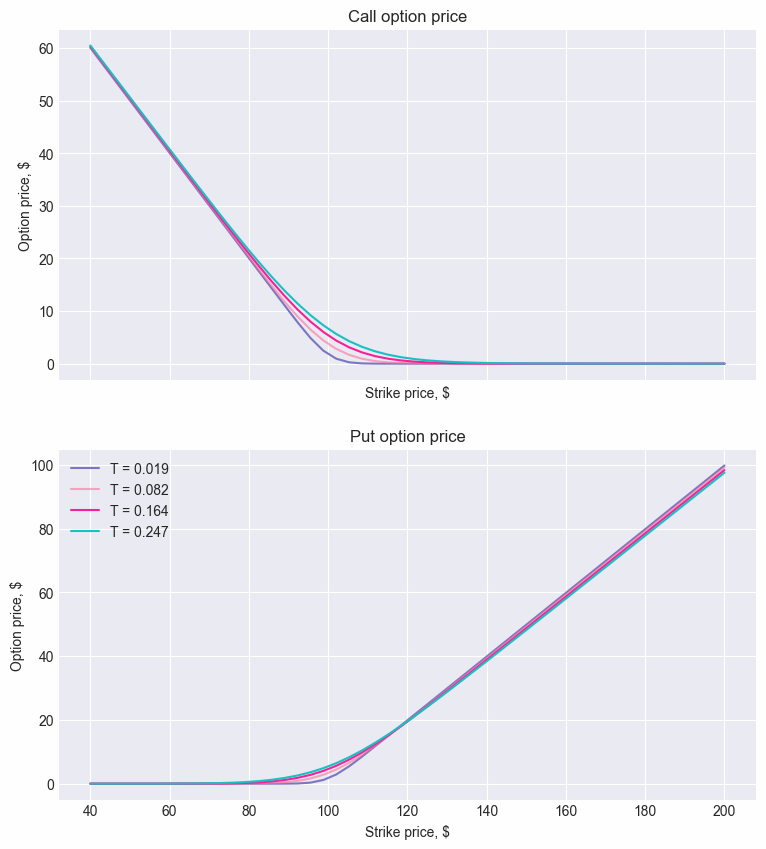

In [15]:

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9, 10))
for t in range(4):
    ax1.plot(strikes, call_price[t, :], label = "T = {}".format(round(float(times[t]), 3)))
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Option price, $')


for t in range(4):
    ax2.plot(strikes, put_price[t, :], label = "T = {}".format(round(float(times[t]), 3)))
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Option price, $')
ax2.legend()
plt.show()

### Task 2: Model calibration (20 points)


Let's recover the model parameters that were used in the prevoius episode.
We start with the set of prices.
It is convinient to quote option prices in terms of Black IV.
First, let's get the forward prices


$$F(t, T) = S_t e^{r(T-t)}.$$

In [16]:
strikes = np.linspace(70, 130, 15)
times = np.array([0.25, 0.5, 0.75, 1.0])

calls = CallStockOption(strike_price=strikes[None], expiration_time=times[:, None])
puts = PutStockOption(strike_price=strikes[None], expiration_time=times[:, None])

call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

C:\Users\Nastia\AppData\Local\Temp\ipykernel_5960\387667140.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  mu_n[i] = nth_moment_heston(n, dt_scalar, params)


In [17]:
forward_prices = ms.stock_price * np.exp(ms.interest_rate * (times - ms.time))
forward_prices

array([101.25784515, 102.53151205, 103.82119971, 105.12710964])

In practive we also do not know the interest rate and know only the zero-coupon bond prices which are called the *discount factors*

$$DF(t, T) = e^{-r(T-t)}$$

In [18]:
discount_factors = np.exp(-ms.interest_rate * (times - ms.time))
discount_factors

array([0.9875778 , 0.97530991, 0.96319442, 0.95122942])

Now let's get the flat vectors of all necessary data and organize it into a DataFrame

In [19]:
k_br, t_br, f_br, df_br = np.broadcast_arrays(
    calls.strike_price,
    calls.expiration_time - ms.time,
    forward_prices[:, None],
    discount_factors[:, None],
)
undisc_calls_price = call_price / df_br

iv = implied_volatility_vec(undisc_calls_price, f_br, k_br, t_br, "c")

In [20]:
df_market_data = pd.DataFrame(dict(
    forward=f_br.flatten(),
    strike=k_br.flatten(),
    tenor=t_br.flatten(),
    discount_factor=df_br.flatten(),
    iv=iv.flatten()
))
df_market_data.head()

forward     strike  tenor  discount_factor        iv
0  101.257845  70.000000   0.25         0.987578  0.368698
1  101.257845  74.285714   0.25         0.987578  0.357312
2  101.257845  78.571429   0.25         0.987578  0.346456
3  101.257845  82.857143   0.25         0.987578  0.336214
4  101.257845  87.142857   0.25         0.987578  0.326736

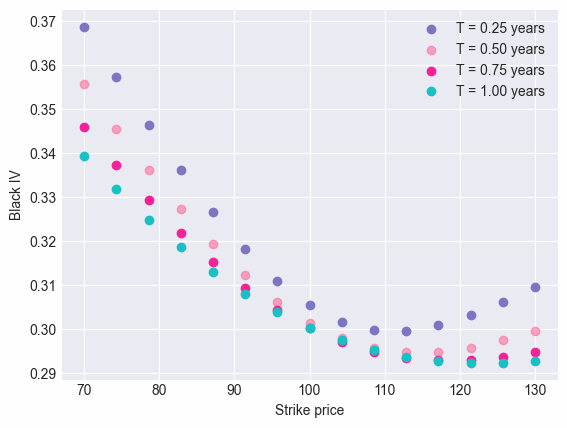

In [21]:
_, ax = plt.subplots()

for tenor in df_market_data.tenor.unique():
    data = df_market_data.query("tenor == @tenor")
    ax.plot(data["strike"], data["iv"], "o", label=f"T = {tenor:.2f} years")

ax.set_xlabel("Strike price")
ax.set_ylabel("Black IV")
ax.legend()
plt.grid(True)
plt.show()

Use the implementation of your COS method (together with truncation range adjustments from the previous tasks) to calibrate the model to the market data  dataframe generated above. 

Your calibration objective function is:
$$
\mathrm{Objective} = 
\frac1{|\mathrm{tenors}|} \sum\limits_{T \sim \mathrm{tenors}}
\frac1{|\mathrm{strikes}|} \sum\limits_{K \sim \mathrm{strikes}}
\bigl( IV_{\text{data}}(T, K) - IV_{\text{model}}(T, K) \bigr)^2
$$

You should recover the Heston parameters used to generate the data. Plot the original data along with the calibrated IV curve (see [Seminar 7](https://github.com/VegaInstitute/C-StochasticVolatility/blob/main/Seminar%207.ipynb), the last plot).

In [22]:
def iv_black_scholes(price: Union[float, np.ndarray], S: float, 
                     K: Union[float, np.ndarray], t: Union[float, np.ndarray], 
                     r: float, is_call: bool):
    """
    Returns implied volatility from given options' prices. 
    """
    return implied_volatility_vec_2(price=price, S=S, K=K, t=t, r=r, flag='c' if is_call else 'p') 


def heston_cf(s, v, kappa, theta, sigma, rho, u, t):
    """Characteristic function of the log-price in the Heston model."""
    d = cmath.sqrt((rho * sigma * u * 1j - kappa) ** 2 + sigma ** 2 * (u * 1j + u ** 2))
    g = ((rho * sigma * u * 1j - kappa + d) / (rho * sigma * u * 1j - kappa - d))
    C = (kappa * theta / sigma ** 2 * (
        t * (kappa - rho * sigma * u * 1j - d) -
        2 * cmath.log((1 - g * cmath.exp(-d * t)) / (1 - g))))
    D = ((kappa - rho * sigma * u * 1j - d) / sigma ** 2 *
         ((1 - cmath.exp(-d * t)) / (1 - g * cmath.exp(-d * t))))
    return cmath.exp(C + D * v + u * math.log(s) * 1j)


def heston_integrand(u, t, k,  s, r, v, kappa, theta, sigma, rho):
    """Integrand in Heston's formula."""
    return (cmath.exp(-1j * u * math.log(k)) / (1j * u) *
            (cmath.exp(r * t) * heston_cf(s, v, kappa, theta, sigma, rho, u - 1j, t) -
             k * heston_cf(s, v, kappa, theta, sigma, rho, u, t))).real


def heston_scalar(t: float, k: float, s: float, r: float, is_call: bool, heston_params: HestonParams) -> float:
    """Computes the price of a call option by Heston's semi-closed formula.

    This is an auxiliary function which works with scalar expiration time
    and strike. It is called by `call_price`, which allows vectorization.
    """
    call_price = (0.5 * (s - math.exp(- r * t) * k) +
                  1 / math.pi * math.exp(- r * t) * 
                  intg.quad(
                    heston_integrand,
                    0, math.inf,
                    args=(t, k, s, r, heston_params.v, heston_params.kappa, heston_params.theta,
                    heston_params.sigma, heston_params.rho))[0])
    if is_call:
        return call_price
    
    return call_price + k * np.exp(- r * t) - s


def heston(t: Union[float, np.ndarray], 
           k: Union[float, np.ndarray], 
           s: float, r: float, 
           is_call: Union[bool, np.ndarray], 
           heston_params: HestonParams) -> Union[float, np.ndarray]:
    """Computes the price of a call option by Heston's semi-closed formula.

        Args:
            t: Expiration time (float or ndarray).
            k: Strike (float or ndarray).
            s: Asset price S_0.
            r: Interest rate r. 

        Returns:
            If `t` and `k` are scalars, returns the price of a call option as a
            scalar value. If `t` and/or `k` are arrays, applies NumPy
            broadcasting rules and returns an array of prices.
    """
    b = np.broadcast(t, k)
    if b.nd:  # Vector arguments were supplied
        return np.fromiter(
            (heston_scalar(t_, k_, s, r, is_call, heston_params) for (t_, k_) in b),
            count=b.size, dtype=float).reshape(b.shape)
    else:
        return heston(t, k, s, r, is_call, heston_params)

In [23]:
def objective(p, tenors, strikes, s, r, iv_data):
    """
    Objective function for Heston model calibration.

    Args:
        p: Heston model parameters (v, kappa, theta, sigma, rho).
        tenors: Array of maturities (T).
        strikes: Array of strikes (K).
        iv_data: 2D array of market implied volatilities IV_data(T, K).
        s: Current spot price of the underlying asset.
        r: Risk-free interest rate.

    Returns:
        Mean squared error between market and model implied volatilities.
    """
    iv_model = np.zeros((len(tenors), len(strikes)))

    for i in range(len(tenors)):
        for j in range(len(strikes)):
            is_call = strikes[j] > s 
            try:
                # Calculate Heston model price
                price = heston_scalar(float(tenors[i]), float(strikes[j]), float(s), float(r), is_call, HestonParams(*p))
                # Calculate implied volatility
                iv_model[i, j] = iv_black_scholes(price, S=s, K=strikes[j], t=tenors[i], r=r, is_call=is_call)
            except Exception:
                iv_model[i, j] = np.nan

    iv_model = iv_model.flatten()
    iv_data = iv_data.flatten()
    error_sum = np.sum((iv_data - iv_model) ** 2)
    
    
    return error_sum / (np.linalg.norm(tenors) * np.linalg.norm(strikes))


In [24]:
def calibrate(t: Union[float, np.ndarray], k: np.ndarray, p:HestonParams,
              iv: np.ndarray, s: float, r: float, min_method: str = "L-BFGS-B"):
        """Calibrates the parameters of the Heston model.

        This function finds the parameters `v`, `kappa`, `sigma`, `theta`,
        `rho` of the model which minimize the objective
        Args:
            t : Expiration time (scalar or array).
            k: Array of strikes.
            iv: Array of market implied volatilities.
            s: Initial price.
            r: Interest rate.
            min_method: Minimization method to be used, as accepted by
                `scipy.optimize.minimize`. The method must be able to handle
                bounds.
        """
        v0 = iv.flatten()[np.abs(k-s).argmin()]**2  # ATM variance


        res = optimize.minimize(
            fun=objective,
            #x0 = (float(p.v), float(p.kappa),float(p.theta),float(p.sigma),float( p.rho)),
            #x0=(v0, 1.0, v0, 1.0, -0.5),  # (v, kappa, theta, sigma, rho)
            x0=(v0, 2, v0, 0.7, -0.2),
            method=min_method,
            args=(t, k, s, r, iv),
            bounds=[(0, math.inf), (0, math.inf), (0, math.inf), (0, math.inf),
                    (-1, 1)])
        return res

In [25]:
s = 100; r = 0.05; is_call=True
heston_params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

In [26]:
res = calibrate(t=times, k=strikes, iv=iv, s=s, r=r, p = heston_params)

In [27]:
def Heston_calibrated(res):
    heston_params_calibrated = HestonParams(*res.x)

    prices_heston_calibrated = np.zeros((times.size, strikes.size))
    ivs_bs_calibrated = np.zeros((times.size, strikes.size))

    for i, strike in enumerate(strikes):
        is_call = True if strike > s else False
        intrinsic_value = max(0, s - strike) if is_call else max(0, strike - s)

        prices_heston_calibrated[:, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_params_calibrated)

        # Ensure prices are above intrinsic value
        if np.any(prices_heston_calibrated[:, i] < intrinsic_value):
            print(f"Warning: Price below intrinsic value at strike {strike}: {prices_heston_calibrated[:, i]}")

        # Safe implied volatility calculation
        try:
            ivs_bs_calibrated[:, i] = iv_black_scholes(price=prices_heston_calibrated[:, i], S=s, K=strike, t=times, r=r, is_call=is_call)
        except  Exception as e:
            print(f"BelowIntrinsicException for strike {strike}: {e}")
            ivs_bs_calibrated[:, i] = np.nan 
    return  ivs_bs_calibrated, prices_heston_calibrated, heston_params_calibrated

In [28]:
ivs_bs_calibrated, prices_heston_calibrated, heston_params_calibrated = Heston_calibrated(res)

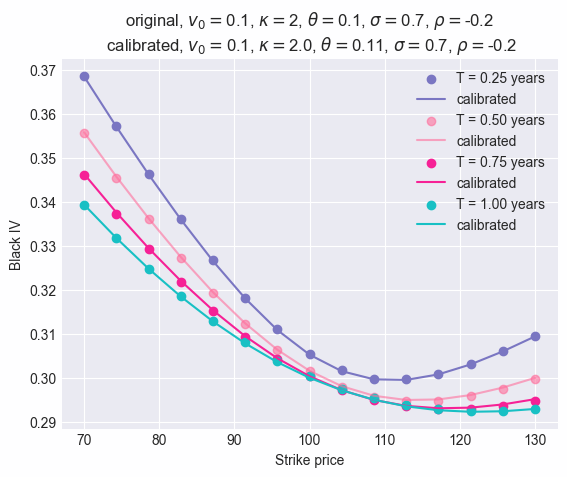

In [29]:
_, ax = plt.subplots()

i =0
for tenor in df_market_data.tenor.unique():
    data = df_market_data.query("tenor == @tenor")
    ax.scatter(data["strike"], data["iv"], label=f"T = {tenor:.2f} years")
    ax.plot(strikes, ivs_bs_calibrated[i,:], label="calibrated")
    i+=1

ax.set_xlabel("Strike price")
ax.set_ylabel("Black IV")
ax.legend()
plt.title("original, $v_0=${}, $\\kappa=${}, $\\theta=${}, $\\sigma=${}, $\\rho=${} \n calibrated, $v_0=${}, $\\kappa=${}, $\\theta=${}, $\\sigma=${}, $\\rho=${}".format(heston_params.v, heston_params.kappa, 
                                                                                                                      heston_params.theta, heston_params.sigma, heston_params.rho, round(heston_params_calibrated.v, 2), round(heston_params_calibrated.kappa, 2), 
                                                                                                                      round(heston_params_calibrated.theta, 2), round(heston_params_calibrated.sigma, 2), round(heston_params_calibrated.rho, 2)) )

plt.grid(True)
plt.show()

### Task 3: Model calibration with bid-ask spread (20 points)

On illiquid markets there is usually a noticable difference between the best buy and the best sell prices for options.
The difference is called the *bid-ask spread*.
We give you a synthetic data obtained with Heston model with some parameters.
The difference is that now you have two prices (correspondingly, two IVs) for each option: the bid price and the ask price.


You will not get the perfect calibration because of the spreads.
The following objective tries to make the IV in the middle of the bid and ask on average:
$$
\mathrm{Objective} = 
\frac1{|\mathrm{tenors}|} \sum\limits_{T \sim \mathrm{tenors}}
\frac1{|\mathrm{strikes}|} \sum\limits_{K \sim \mathrm{strikes}}
\frac12 \sum\limits_{\mathrm{side} \in \{ \text{bid}, \text{ask} \}}
\bigl( IV_{\text{data}}(T, K, \mathrm{side}) - IV_{\text{model}}(T, K) \bigr)^2
$$

Implement this objective and calibrate the model to the synthetic data with spread.

In [30]:
df_market_data = pd.read_csv("synth_bid_ask.csv")
df_market_data.head()

forward     strike  tenor  discount_factor    bid_iv    ask_iv
0  100.75282  70.000000   0.25         0.992528  0.406888  0.446888
1  100.75282  74.285714   0.25         0.992528  0.394230  0.434230
2  100.75282  78.571429   0.25         0.992528  0.381944  0.421944
3  100.75282  82.857143   0.25         0.992528  0.370030  0.410030
4  100.75282  87.142857   0.25         0.992528  0.358515  0.398515

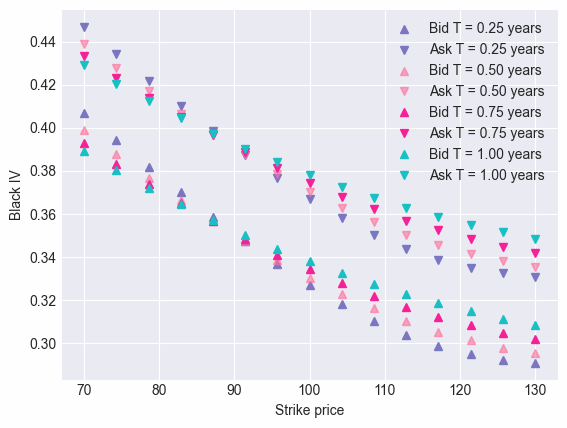

In [31]:
_, ax = plt.subplots()

for i, tenor in enumerate(df_market_data.tenor.unique()):
    data = df_market_data.query("tenor == @tenor")
    ax.plot(data["strike"], data["bid_iv"], "^", label=f"Bid T = {tenor:.2f} years", c=f"C{i}")
    ax.plot(data["strike"], data["ask_iv"], "v", label=f"Ask T = {tenor:.2f} years", c=f"C{i}")

ax.set_xlabel("Strike price")
ax.set_ylabel("Black IV")
ax.legend()
plt.grid(True)
plt.show()

Calibrate the model to the data with bid-ask spread and plot the graph with market data and calibrated model.

In [32]:
def objective_bid_ask(p, tenors, strikes, s, r, iv_data_bid, iv_data_ask):
    """
    Objective function for Heston model calibration with bid-ask spread.

    Args:
        p: Heston model parameters (v, kappa, theta, sigma, rho).
        tenors: Array of maturities (T).
        strikes: Array of strikes (K).
        iv_data_bid: 2D array of market bid implied volatilities IV_data(T, K, bid).
        iv_data_ask: 2D array of market ask implied volatilities IV_data(T, K, ask).
        s: Current spot price of the underlying asset.
        r: Risk-free interest rate.

    Returns:
        Mean squared error between model IV and bidIV, askIV.
    """
    

    iv_model = np.zeros((len(tenors), len(strikes)))
    
    for i in range(len(tenors)):
        for j in range(len(strikes)):
            is_call = strikes[j] > s  
            try:
                
                price = heston_scalar(float(tenors[i]), float(strikes[j]), float(s), float(r), is_call, HestonParams(*p))
                
                iv_model[i, j] = iv_black_scholes(price, S=s, K=strikes[j], t=tenors[i], r=r, is_call=is_call)
            except Exception:
                iv_model[i, j] = np.nan
    
    iv_model = iv_model.flatten()
    error_sum = np.sum((iv_data_bid - iv_model) ** 2 + (iv_data_ask - iv_model)**2)/2.0
    
    return error_sum / (np.linalg.norm(tenors) * np.linalg.norm(strikes))


In [33]:
def calibrate_bid_ask(t: Union[float, np.ndarray], k: np.ndarray, p:HestonParams,
              iv_data_bid: np.ndarray, iv_data_ask: np.ndarray, s: float, r: float, min_method: str = "L-BFGS-B"):
        """Calibrates the parameters of the Heston model.

        This function finds the parameters `v`, `kappa`, `sigma`, `theta`,
        `rho` of the model which minimize the objective

        Args:
            t : Expiration time (scalar or array).
            k: Array of strikes.
            iv_data_bid: Array of bid implied volatilities.
            iv_data_ask: Array of bid implied volatilities.
            s: Initial price.
            r: Interest rate.
            min_method: Minimization method to be used, as accepted by
                `scipy.optimize.minimize`. The method must be able to handle
                bounds.
        """
        iv_data_mid = 0.5*(iv_data_bid + iv_data_ask)
        v0 = iv_data_mid.flatten()[np.abs(k-s).argmin()]**2  # ATM variance

        res = optimize.minimize(
            fun=objective_bid_ask,
            x0=(v0, 2, v0, 0.7, -0.2),
            method = min_method,
            args=(t, k, s, r, iv_data_bid, iv_data_ask),
            bounds=[(0, math.inf), (0, math.inf), (0, math.inf), (0, math.inf),
                    (-1, 1)])
        return res

In [34]:
ask_iv = df_market_data["ask_iv"].to_numpy()
bid_iv = df_market_data["bid_iv"].to_numpy()

In [35]:
res = calibrate_bid_ask(t=times, k=strikes, iv_data_bid=bid_iv, iv_data_ask=ask_iv, s=s, r=r, p = heston_params)
ivs_bs_calibrated, prices_heston_calibrated, heston_params_calibrated = Heston_calibrated(res)

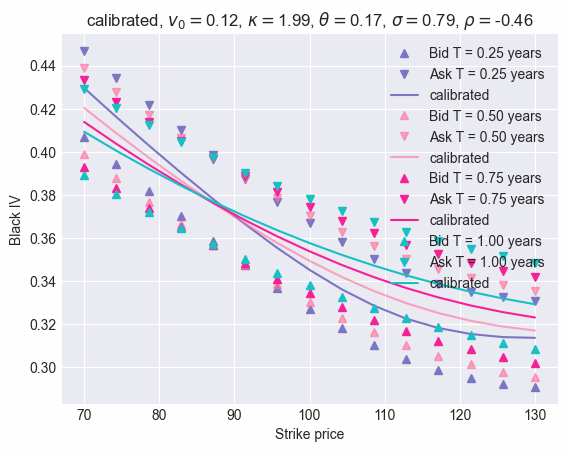

In [36]:
_, ax = plt.subplots()

for i, tenor in enumerate(df_market_data.tenor.unique()):
    data = df_market_data.query("tenor == @tenor")
    ax.plot(data["strike"], data["bid_iv"], "^", label=f"Bid T = {tenor:.2f} years", c=f"C{i}")
    ax.plot(data["strike"], data["ask_iv"], "v", label=f"Ask T = {tenor:.2f} years", c=f"C{i}")
    ax.plot(strikes, ivs_bs_calibrated[i,:], label="calibrated")
    #ax.plot(strikes, ivs_bs_calibrated_ask[i,:], label="calibrated ask")
    #ax.plot(strikes, ivs_bs_calibrated_bid[i,:], label="calibrated bid")
ax.set_xlabel("Strike price")
ax.set_ylabel("Black IV")
plt.title("calibrated, $v_0=${}, $\\kappa=${}, $\\theta=${}, $\\sigma=${}, $\\rho=${}".format(round(heston_params_calibrated.v, 2), round(heston_params_calibrated.kappa, 2), 
        round(heston_params_calibrated.theta, 2), round(heston_params_calibrated.sigma, 2), round(heston_params_calibrated.rho, 2)) )

ax.legend()
plt.grid(True)
plt.show()

## Episode 2: Capturing the response 🧠 (40 points)

### Task 4: Calibration to smile and response

Assume that you are a trader on a vanilla derivatives desk and every day you observe on the market the implied volatilities for vanilla options contracts. In order to conduct an appropriate hedging strategy, you need to capture the volatility dynamics observing on the market. For some reason, your choice is the Heston stochastic volatility model. 

For the sake of simplicity, you are dealing only with option contracts for one time to expiration $T=1$ year (that is, you observe on the market the implied volatility curve rather than the whole surface) and you have two snapshots of this market for subsequent dates *18/11/2024* and *19/11/2024*.

Hence, given two implied volatility curves, you wish your calibration to meet two requirements:

* The model is calibrated to the implied volatility curve observed at *18/11/2024*.

* The **same** model provides a correct implied volatility response, that is when the spot $S$ changes from $S=150$ to $S=154.5$ on *19/11/2024*, the implied volatilities provided from the model move the same way as it goes on the market. 

Provide a model calibartion algorithm which meets the requreiemtns above. The answer should contain a set of calibrated Heston model paramters together with the plots showing that the corresponding model provides an appropriate implied volatility curve and volatility response.

For this task you may use any pricing algorithm (Carr-Madan, COS method, direct integration, etc.) in Heston model you wish. 

In [37]:
file_name = "response_calibration.csv"
df = pd.read_csv(file_name, index_col=0)
df.head()

IV_t(K)  IV_{t+1}(K)  S_t  S_{t+1}       K  T     r
0  0.217310     0.229206  150    154.5  127.50  1  0.05
1  0.188706     0.201528  150    154.5  138.75  1  0.05
2  0.158467     0.173783  150    154.5  150.00  1  0.05
3  0.136581     0.146240  150    154.5  161.25  1  0.05
4  0.126814     0.127843  150    154.5  172.50  1  0.05

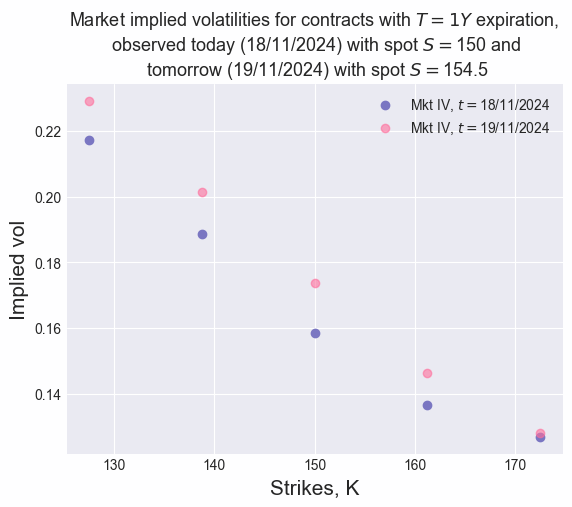

In [38]:
plt.scatter(df["K"], df["IV_t(K)"], label="Mkt IV, $t=$18/11/2024")
plt.scatter(df["K"], df["IV_{t+1}(K)"], label="Mkt IV, $t=$19/11/2024")
plt.title("Market implied volatilities for contracts with $T=1Y$ expiration, \n observed today (18/11/2024) with spot $S=${} and \n tomorrow (19/11/2024) with spot $S=${}".format(df["S_t"].values[0], df["S_{t+1}"].values[0]), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

In [39]:
strikes = np.linspace(df["K"].min(), df["K"].max(), 50)
S = 150
S_ = 154.5
r = 0.05
times = np.array([1.0,])



In [40]:
iv_df18 = df["IV_t(K)"].to_numpy()
iv_df19= df["IV_{t+1}(K)"].to_numpy()

In [41]:
def objective_18_19(p, tenors, strikes, s18, s19, r, iv_data18, iv_data19):
    """
    Objective function for Heston model calibration with two spots.
    Args:
        p: Heston model parameters (v, kappa, theta, sigma, rho).
        tenors: Array of maturities (T).
        strikes: Array of strikes (K).
        iv_data18: 2D array of market bid implied volatilities IV_data(T, K, 18).
        iv_data19: 2D array of market ask implied volatilities IV_data(T, K, 19).
        s18: Current spot price of the underlying asset at the first day.
        s18: Current spot price of the underlying asset at the second day.
        r: Risk-free interest rate.

    Returns:
        Mean squared error between model and IV at different spots.
    """
    

    iv_model18 = np.zeros((len(tenors), len(strikes)))
    iv_model19 = np.zeros((len(tenors), len(strikes)))
    
    for i in range(len(tenors)):
        for j in range(len(strikes)):
            is_call = strikes[j] > s  #
            try:
                
                price18 = heston_scalar(float(tenors[i]), float(strikes[j]), float(s18), float(r), is_call, HestonParams(*p))
                price19 = heston_scalar(float(tenors[i]), float(strikes[j]), float(s19), float(r), is_call, HestonParams(*p))
                
                iv_model18[i, j] = iv_black_scholes(price18, S=s18, K=strikes[j], t=tenors[i], r=r, is_call=is_call)
                iv_model19[i, j] = iv_black_scholes(price19, S=s19, K=strikes[j], t=tenors[i], r=r, is_call=is_call)
            except Exception:
                iv_model18[i, j] = np.nan
                iv_model19[i, j] = np.nan
    
    iv_model18 = iv_model18.flatten()
    iv_model19 = iv_model19.flatten()
    error_sum = np.sum((iv_data18 - iv_model18) ** 2 + (iv_data19 - iv_model19)**2)/2.0
    
    return error_sum / (np.linalg.norm(tenors) * np.linalg.norm(strikes))

In [42]:
from scipy.interpolate import interp1d

In [43]:
def calibrate_18_19(t: Union[float, np.ndarray], k: np.ndarray, true_K: np.ndarray, p:HestonParams,
              iv_data18: np.ndarray, iv_data19: np.ndarray, s18: float,s19: float, r: float, min_method: str = "L-BFGS-B"):
        """Calibrates the parameters of the Heston model.

        This function finds the parameters `v`, `kappa`, `sigma`, `theta`,
        `rho` of the model which minimize the sum of squares of the differences
        between market and model implied volatilities. Returns an instance of
        the class with the calibrated parameters.

        Args:
            t : Expiration time (scalar or array).
            k: Array of strikes.
            iv: Array of market implied volatilities.
            s: Initial price.
            r: Interest rate.
            min_method: Minimization method to be used, as accepted by
                `scipy.optimize.minimize`. The method must be able to handle
                bounds.
        """
        iv_interpolator = interp1d(true_K, iv_data18, kind="linear", fill_value="extrapolate")
        atm_iv = iv_interpolator(s18)  # Interpolate the implied volatility at s18
        v0 = atm_iv**2

        res = optimize.minimize(
            fun=objective_18_19,
            x0=(v0, 2, v0, 0.7, -0.2),
            method = min_method,
            args=(t, true_K, s18, s19, r, iv_data18, iv_data19),
            bounds=[(0, math.inf), (0, math.inf), (0, math.inf), (0, math.inf),
                    (-1, 1)])
        return res

In [44]:
res = calibrate_18_19(t=times, k=strikes, iv_data18=iv_df18, iv_data19=iv_df19, s18=S, s19=S_, p = heston_params, r = r, true_K=df["K"].to_numpy())

In [45]:

heston_params_calibrated = HestonParams(*res.x)

prices_heston_calibrated18 = np.zeros((times.size, strikes.size))
ivs_bs_calibrated18 = np.zeros((times.size, strikes.size))

prices_heston_calibrated19 = np.zeros((times.size, strikes.size))
ivs_bs_calibrated19 = np.zeros((times.size, strikes.size))

for i, strike in enumerate(strikes):
    is_call = True if strike > S else False
    intrinsic_value = max(0, S - strike) if is_call else max(0, strike - S)

    prices_heston_calibrated18[:, i] = heston(t=times, k=strike, s=S, r=r, is_call=is_call, heston_params=heston_params_calibrated)
    prices_heston_calibrated19[:, i] = heston(t=times, k=strike, s=S_, r=r, is_call=is_call, heston_params=heston_params_calibrated)
    
    if np.any(prices_heston_calibrated18[:, i] < intrinsic_value):
        print(f"Warning: Price below intrinsic value at strike {strike}: {prices_heston_calibrated18[:, i]}")
    
    try:
        ivs_bs_calibrated18[:, i] = iv_black_scholes(price=prices_heston_calibrated18[:, i], S=S, K=strike, t=times, r=r, is_call=is_call)
        ivs_bs_calibrated19[:, i] = iv_black_scholes(price=prices_heston_calibrated19[:, i], S=S_, K=strike, t=times, r=r, is_call=is_call)
    except  Exception as e:
        print(f"BelowIntrinsicException for strike {strike}: {e}")
        ivs_bs_calibrated18[:, i] = np.nan  
        ivs_bs_calibrated19[:, i] = np.nan  

Answer:

In [46]:
print("calibrated Heston model paramters:\n \n v_0   = {}\n kappa = {}\n theta = {}\n sigma = {}\n rho   = {}".format(round(heston_params_calibrated.v, 2), round(heston_params_calibrated.kappa, 2), 
        round(heston_params_calibrated.theta, 2), round(heston_params_calibrated.sigma, 2), round(heston_params_calibrated.rho, 2)) )


calibrated Heston model paramters:
 
 v_0   = 0.09
 kappa = 1.98
 theta = 0.0
 sigma = 0.83
 rho   = -0.51


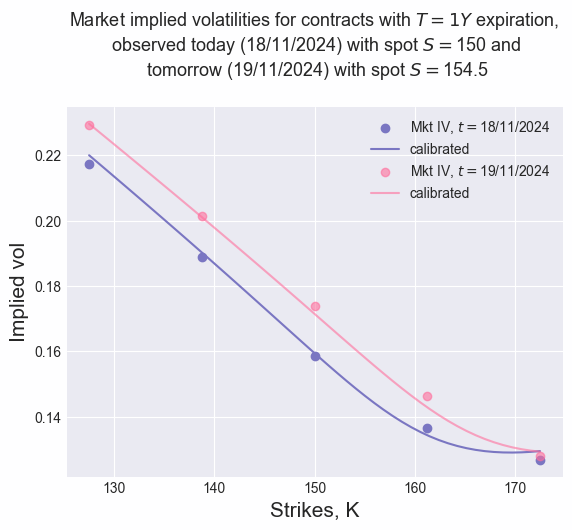

In [47]:
plt.scatter(df["K"], df["IV_t(K)"], label="Mkt IV, $t=$18/11/2024")
plt.plot(strikes, ivs_bs_calibrated18[0, :],label="calibrated")
plt.scatter(df["K"], df["IV_{t+1}(K)"], label="Mkt IV, $t=$19/11/2024")
plt.plot(strikes, ivs_bs_calibrated19[0, :],label="calibrated")

plt.title("Market implied volatilities for contracts with $T=1Y$ expiration, \n observed today (18/11/2024) with spot $S=${} and \n tomorrow (19/11/2024) with spot $S=${}\n".format(df["S_t"].values[0], df["S_{t+1}"].values[0]), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

## Episode 3: Memes (10 points) ⚰️

Come up with a funny financial math meme. If the meme is not funny, then we will have to deduct points. Don't steal memes, come up with your own!

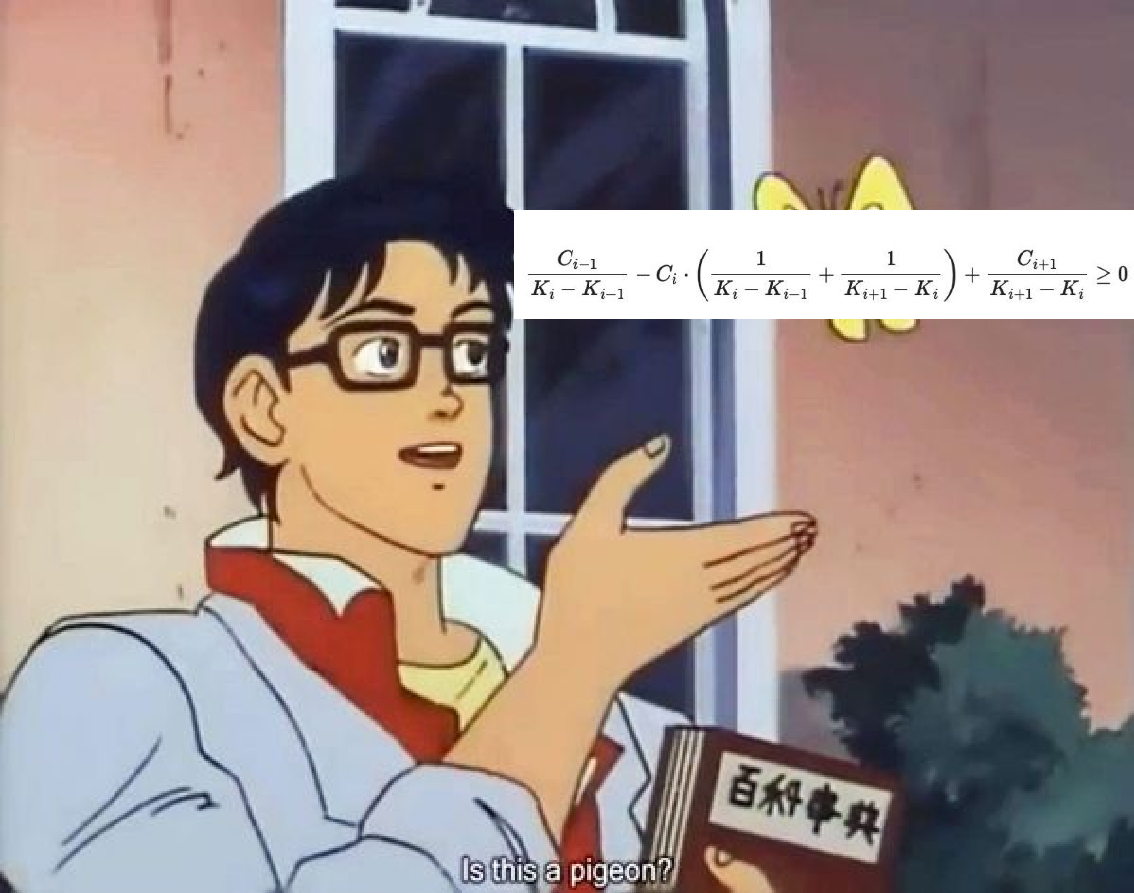

Next meme has two versions: kind, with a cat and the classical one

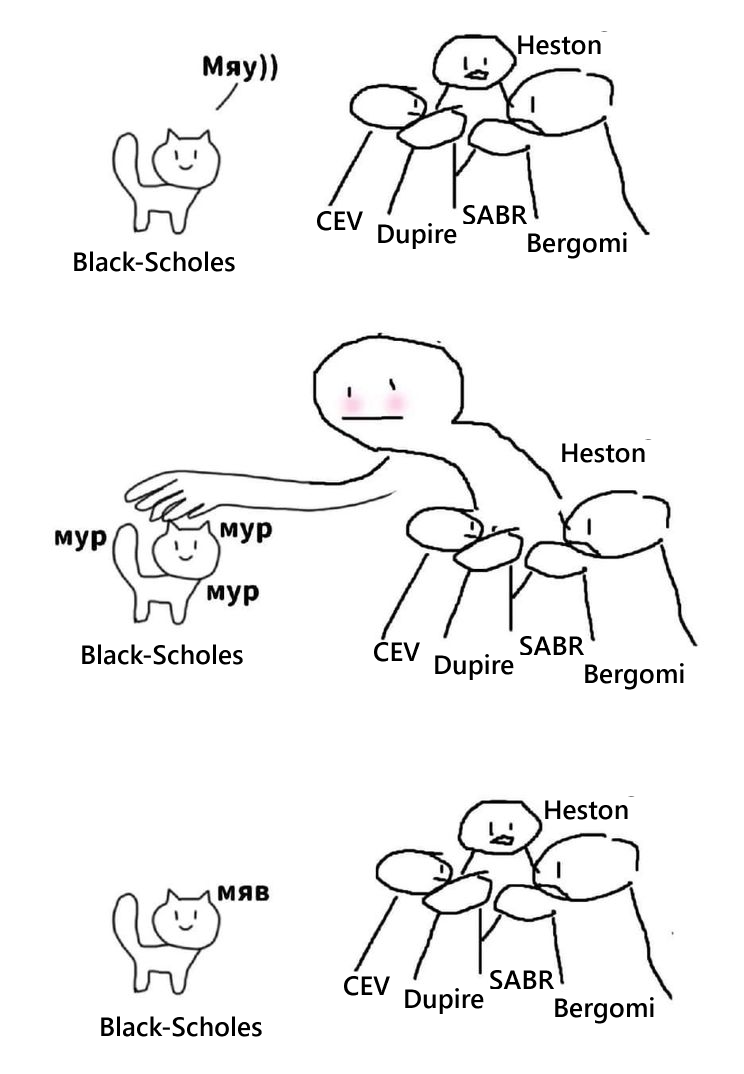

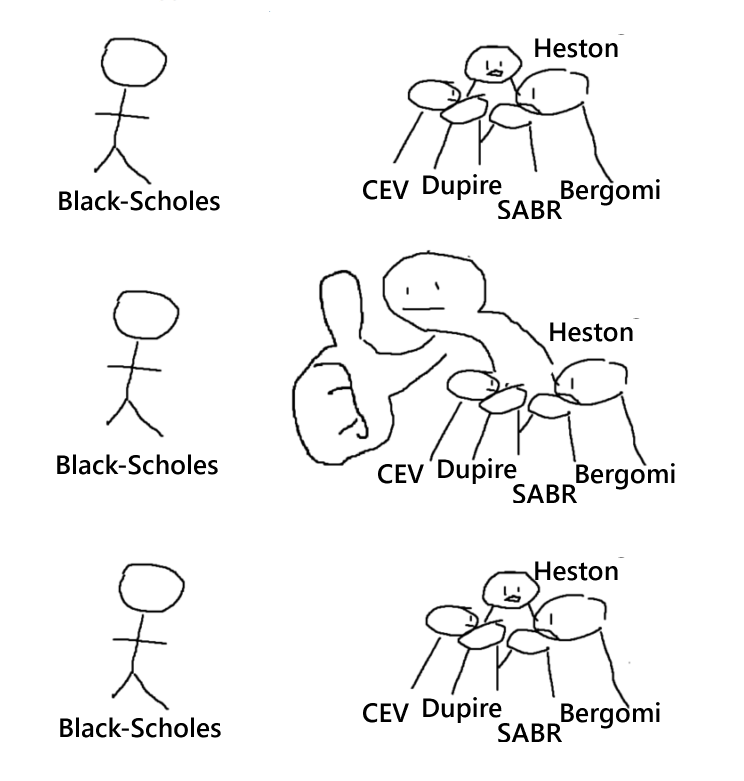
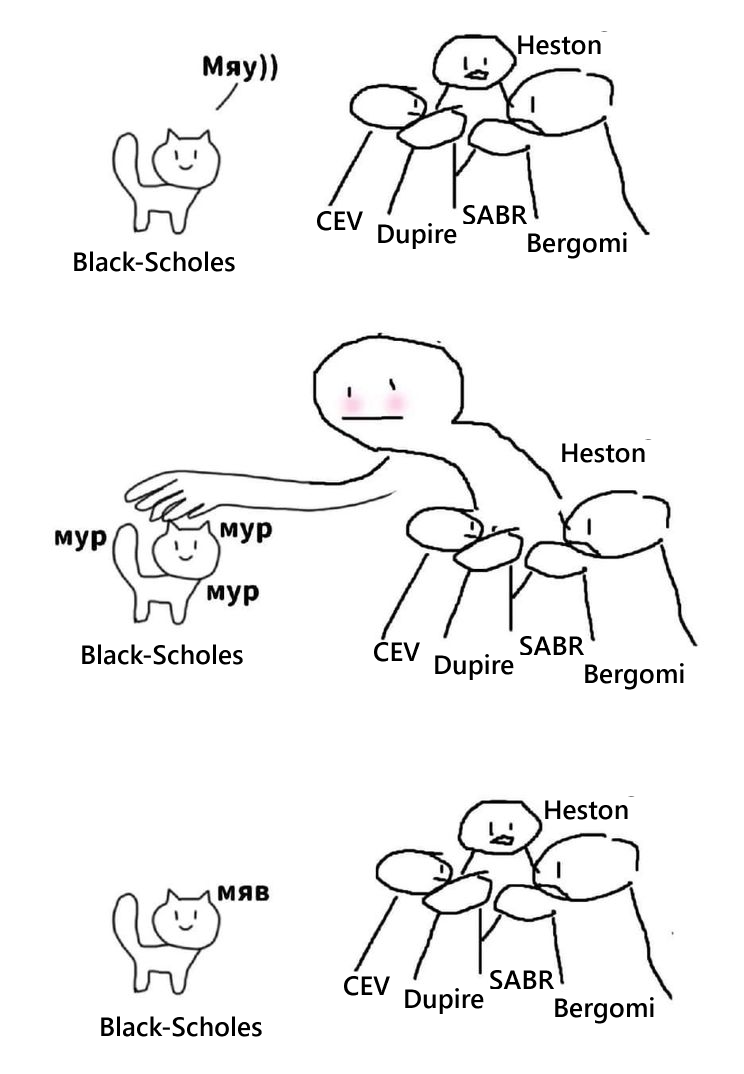
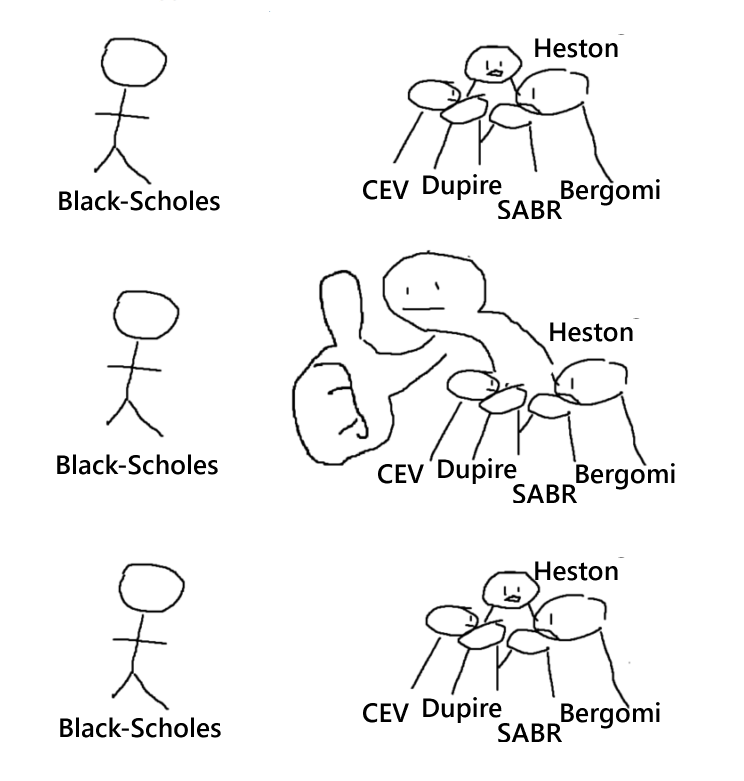

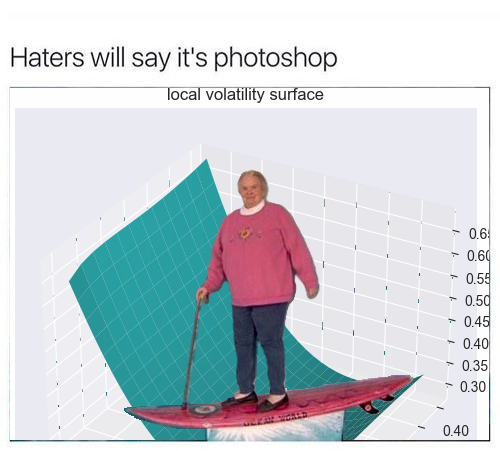

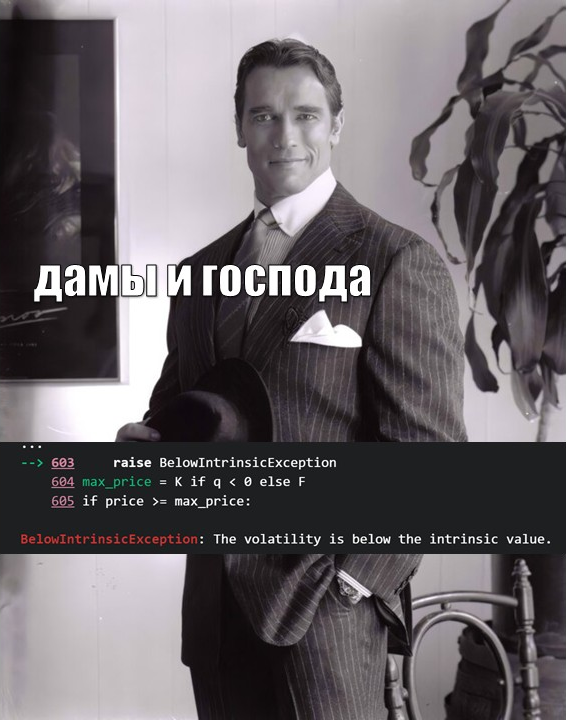

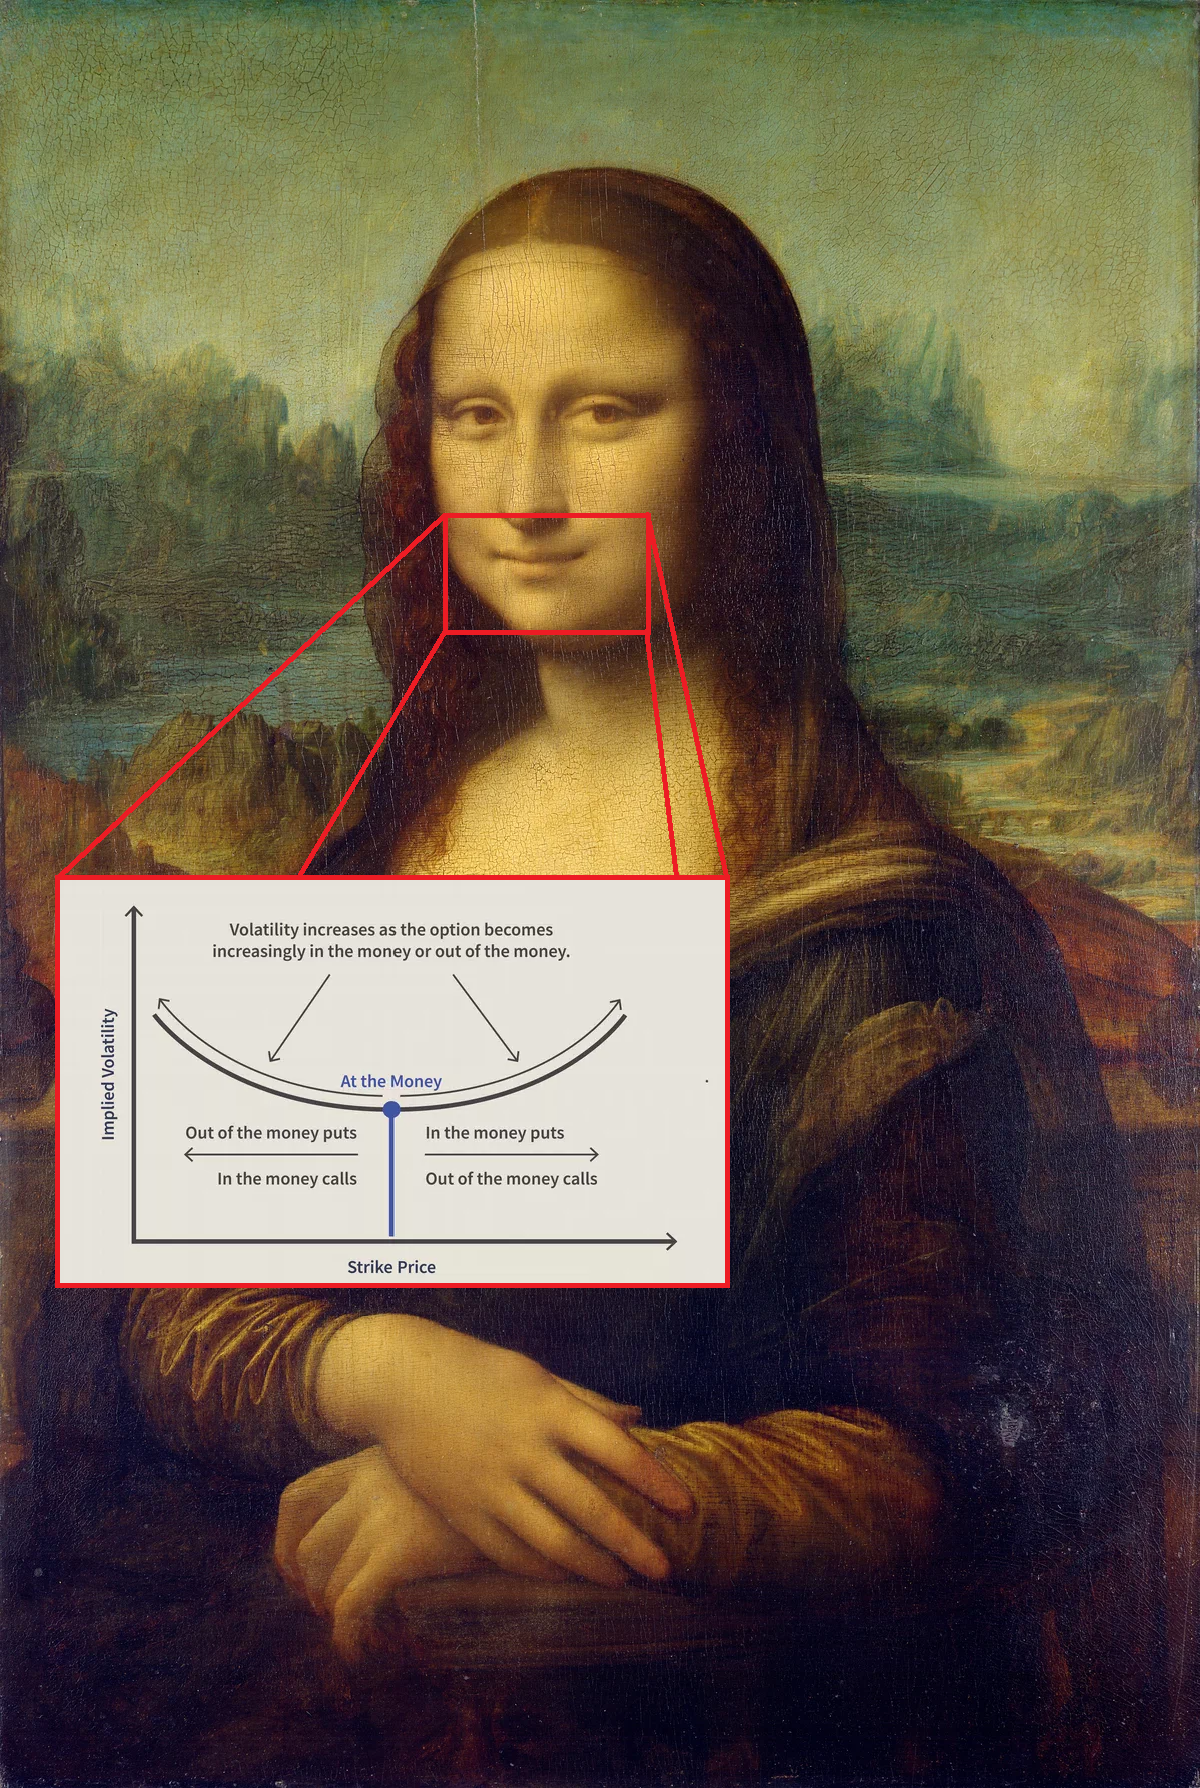

## References

1. Fang, Fang and Cornelis W. Oosterlee. “A Novel Pricing Method for European Options Based on Fourier-Cosine Series Expansions.” *SIAM J. Sci. Comput*. 31 (2008): 826-848.

2. Junike, Gero & Pankrashkin, Konstantin, 2022. "*Precise option pricing by the COS method—How to choose the truncation range*" Applied Mathematics and Computation, Elsevier, vol. 421(C).